# Deep Learning for audio Lecture 1 (Introduction)


Usefull links
1. Great web based plotting tool: https://www.desmos.com/calculator
2. Fourier tranform explanation (3blue1brown): https://www.youtube.com/watch?v=spUNpyF58BY
5. Tutorials on FFT/MFCC/VAD: http://practicalcryptography.com/miscellaneous/machine-learning/

In [15]:
import pathlib

import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import display, Audio
%matplotlib inline

# Physics of sound

Sound is a wave or oscilation represented by air preasure disturbance cuased by vibration.

Sound is a movement of air.

Preconditions for a sound hearable by a human:
 - source of vibration: guitar string, human voice, antyhing that vibrates in a hearable range of frequencies (20 - 20k Hz)
 - elastic medium: air mulecules, watter.

Interactive intorduction to waveforms: https://pudding.cool/2018/02/waveforms/

Waveform properties:
 - frequency - number of full cycles per 1 second
 - amplitude - roughly equivalent to loudness

In [12]:
import jp_proxy_widget
src = "https://www.desmos.com/api/v1.2/calculator.js?apiKey=dcb31709b452b1cf9dc26972add0fda6"
widget = jp_proxy_widget.JSProxyWidget()
widget.load_js_files([src])

In [13]:
widget.js_init(
"""
    element.width(1000).height(600);
    element.calculator = Desmos.GraphingCalculator(element[0]);
    element.calculator.setExpression({id:'graph1', latex:'y=sin(x)', type:'expression'});
"""
)
widget

JSProxyWidget(status='deferring flush until render')

# Digital Audio representation

Sampling - take a continues wave and discritize it. 

**Sampling rate** - density of discretization. Common values (8000 Hz, 16000 Hz, 22050 Hz, 44100 Hz)
- 44100 Hz - can represent 20 kHz, maximum audible frequency by humans.
- 22050 Hz - Speech Synthesis models. was used for low bit rate MP3 in the past.
- 16000 Hz - widely used for training ASR models. Can represent human speech frequency spectrum (200 Hz - 8 kHz)
- 8000 Hz - telephone, encrypted walkie-talkie, adequate for human speech, but without fricative sounds /s/ /f/


**Bit depth** - resolution of each sample. 16 bit, 8 bit. etc.

$$ bit\_rate = sampling\_rate * bit\_depth $$

https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem

https://en.wikipedia.org/wiki/Sampling_(signal_processing)#Applications

# SoX - Sound eXchange


The Swiss Army knife of audio manipulation, like ffmpeg for video.


- query usefull audio properties via __soxi__

```
(venv) tarragon:data taras$ soxi LJ037-0171.wav

Input File     : 'LJ037-0171.wav'
Channels       : 1
Sample Rate    : 22050
Precision      : 16-bit
Duration       : 00:00:07.58 = 167226 samples ~ 568.796 CDDA sectors
File Size      : 334k
Bit Rate       : 353k
Sample Encoding: 16-bit Signed Integer PCM
```

- resample audio

```
(venv) tarragon:data taras$ sox LJ037-0171.wav LJ037-0171.8k.wav rate 8000
(venv) tarragon:data taras$ soxi LJ037-0171.8k.wav

Input File     : 'LJ037-0171.8k.wav'
Channels       : 1
Sample Rate    : 8000
Precision      : 16-bit
Duration       : 00:00:07.58 = 60672 samples ~ 568.8 CDDA sectors
File Size      : 121k
Bit Rate       : 128k
Sample Encoding: 16-bit Signed Integer PCM
```

- play audio directly in terminal!

```
(venv) tarragon:data taras$ play LJ037-0171.wav

LJ037-0171.wav:

 File Size: 334k      Bit Rate: 353k
  Encoding: Signed PCM
  Channels: 1 @ 16-bit
Samplerate: 22050Hz
Replaygain: off
  Duration: 00:00:07.58

In:58.8% 00:00:04.46 [00:00:03.13] Out:168k  [  -===|===-  ]        Clip:0
```

# Other usefull audio processing tools and libraries

- [Audacity](https://www.audacityteam.org/) opensource GUI for audio recording,editting, convenient manipulations.
- [Librosa](https://librosa.org/doc/latest/index.html) convenient python library for audio feature extraction, manipulation, and builidng ML pipelines. Gradually looses it's importance, perpahs due to emergence of more end-to-end models.
- [PyTorch Audio](https://github.com/pytorch/audio) seamless integration with PyTorch, under active development, still not mature but promissing library.
- [FFmpeg](https://ffmpeg.org/) Indispensible tool when you work with audio and video, provides all SoX's features and more.

# Audio Spectral Representations

- Spectrograms(STFT)
- Mel-spectrograms
- Gammatones


# Discrete Fourier Transform

$$ {\huge X_k = \sum_{n=0}^{N-1} x_n \cdot e ^ {\frac{-i2\pi}{N}kn} } $$ 

Key Idea! Represent complex waveform with sinusoids of various frequencies

In [18]:
def dft(x):
    # Naive implementation of Discrete Fourier transform (DFT)
    # https://en.wikipedia.org/wiki/Discrete_Fourier_transform
    assert x.ndim == 1
    N = x.shape[0]
    K = x.shape[0]
    spectrum = np.zeros_like(x, dtype=np.complex)
    for i in range(K):
        for j in range(N):
            spectrum[i] += x[j] * np.exp(-1j * 2 * np.pi * i * j / N)
            
    return spectrum

def my_complex_abs(x):
    # |x| = sqrt(a^2 + b^2)
    assert x.dtype == np.complex
    return np.sqrt(x.real**2 + x.imag**2)

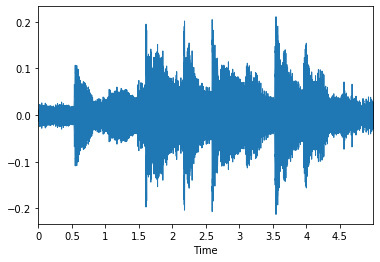

In [16]:
audio_path = 'data/wav_22050/piano.22050.wav'
audio_waveform, sampling_rate = librosa.core.load(audio_path, sr=None, duration=5.0, offset=5.0)
audio_waveform = audio_waveform[:sampling_rate * 5]

librosa.display.waveplot(audio_waveform, sr=sampling_rate)
Audio(data=audio_waveform, rate=sampling_rate)

Text(0.5, 1.0, 'onesided DFT')

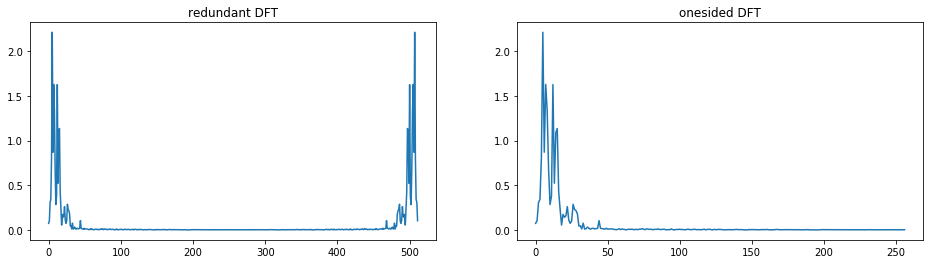

In [19]:
spectrum = my_complex_abs(dft(audio_waveform[-512:]))
spectrum_2 = my_complex_abs(np.fft.fft(audio_waveform[-512:]))

assert np.allclose(spectrum, spectrum_2)

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].plot(spectrum)
axes[0].set_title('redundant DFT')
axes[1].plot(spectrum[:256+1])
axes[1].set_title('onesided DFT')

# Spectrogram, ShortTimeFourierTransform (STFT)

- Key Idea, slide over waveform with a window and compute DFT, concatenate DFT's for each window in a single 2D Matrix.
- has a well defined inverse transformation iSTFT

![stft_viz](./assets/stft_output.png)
image take from [MathWorks](https://www.mathworks.com/help/dsp/ref/dsp.stft.html)

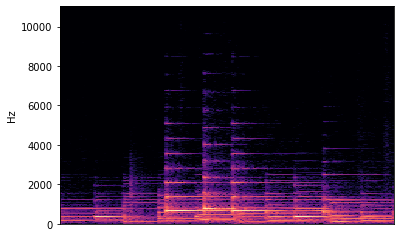

In [20]:
audio_stft = librosa.stft(audio_waveform)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(audio_stft), ref=np.max), y_axis='linear')

# Mel-Spectrogram

- Perceptual scale of pitches equal in distance from one another.
- Mel comes from melody, to indicate that name comes from pitch comparison.
- Mel-spectrogram is obtained from stft by one more matrix multiplication with mel-filterbank
- Intuitively shows that humans distiguish low frequencies better then high frequencies.

Text(0.5, 1.0, 'Mel Basis')

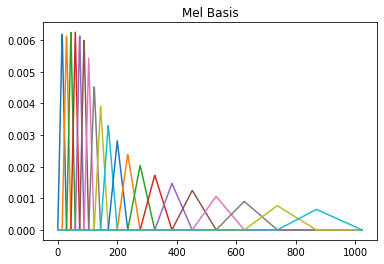

In [107]:
n_mels = 20
mel_basis = librosa.filters.mel(sr=sampling_rate, n_fft=2048, n_mels=n_mels)
for i in range(n_mels):
    plt.plot(mel_basis[i, :])
plt.title('Mel Basis')

# Gammatones. Slaney, 1998

- Spectrogram like represnetations based on modelling how the human ear perceives, emphasises and separates different frequencies of sound.
- Gammatone should represent the human experience of sound better than, say, a Fourier-domain spectrum.
- Approximate version of Gammatones can be computed from Spectrogramms.


In [21]:
from gammatone import gtgram
# https://github.com/detly/gammatone
def compute_gammatone(wav):
    window_time = 0.02
    hop_time = window_time / 2
    channels = 120
    f_min = 20
    gtg = gtgram.gtgram(wav, sampling_rate, window_time, hop_time, channels, f_min)
    gtg = np.flipud(20 * np.log10(gtg))
    return gtg

piano.22050.wav


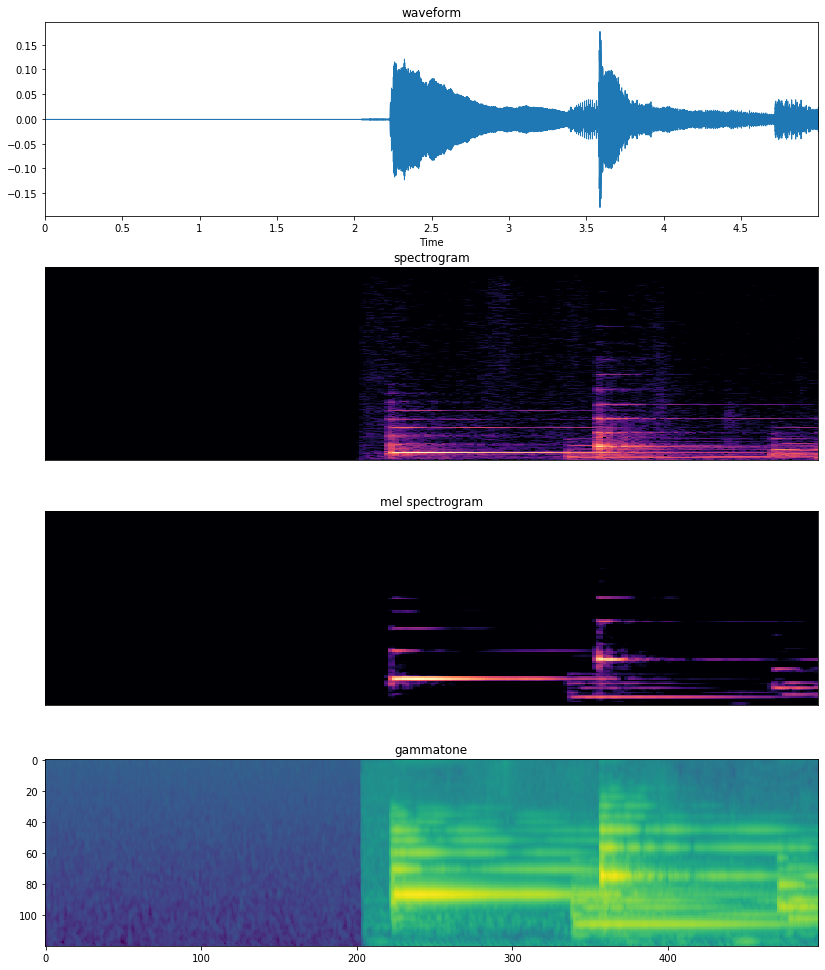

water-pour.22050.wav


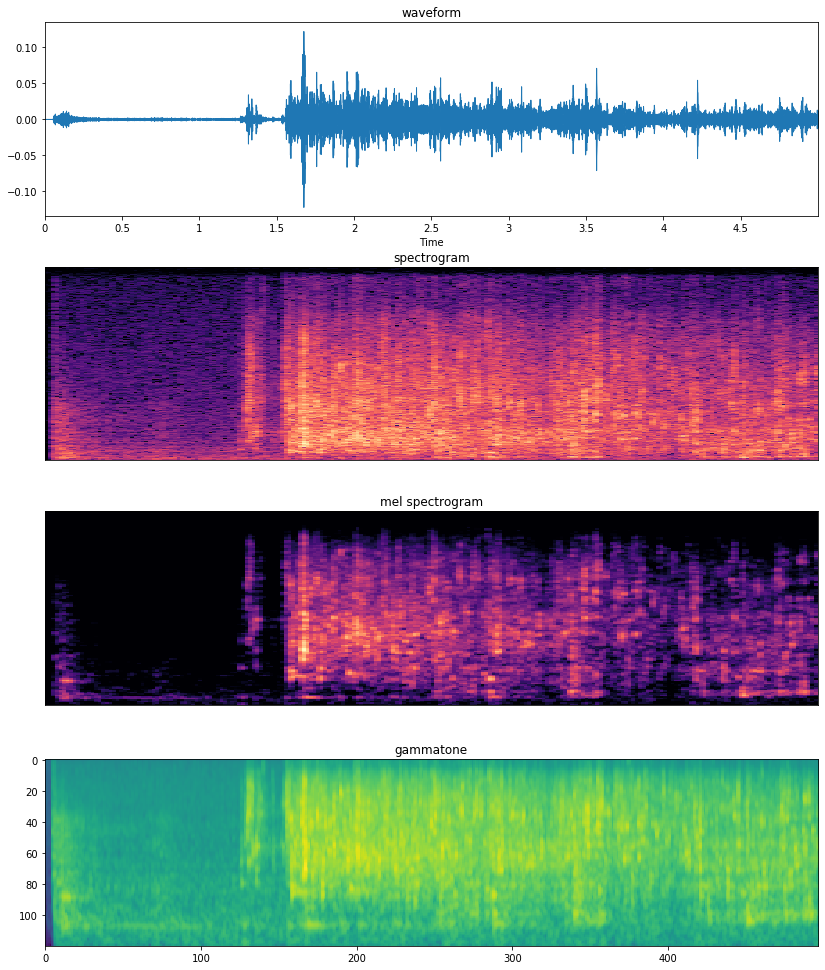

thunder-close.22050.wav


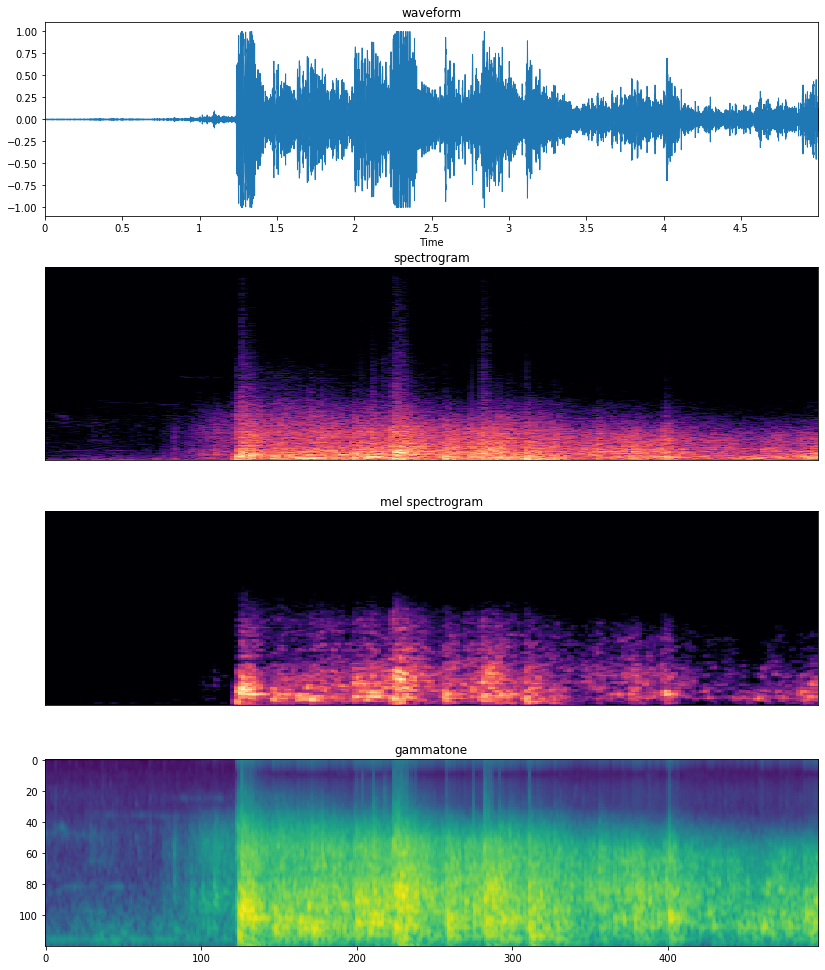

lj_speech.22050.wav


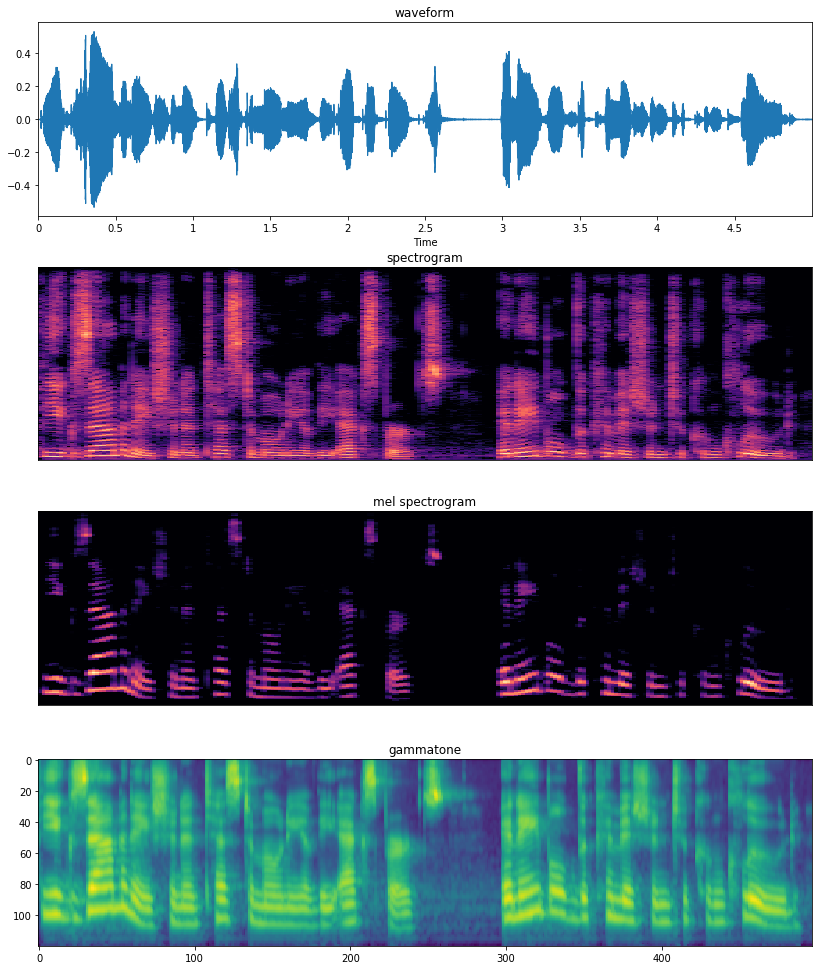

bird-whistling.22050.wav


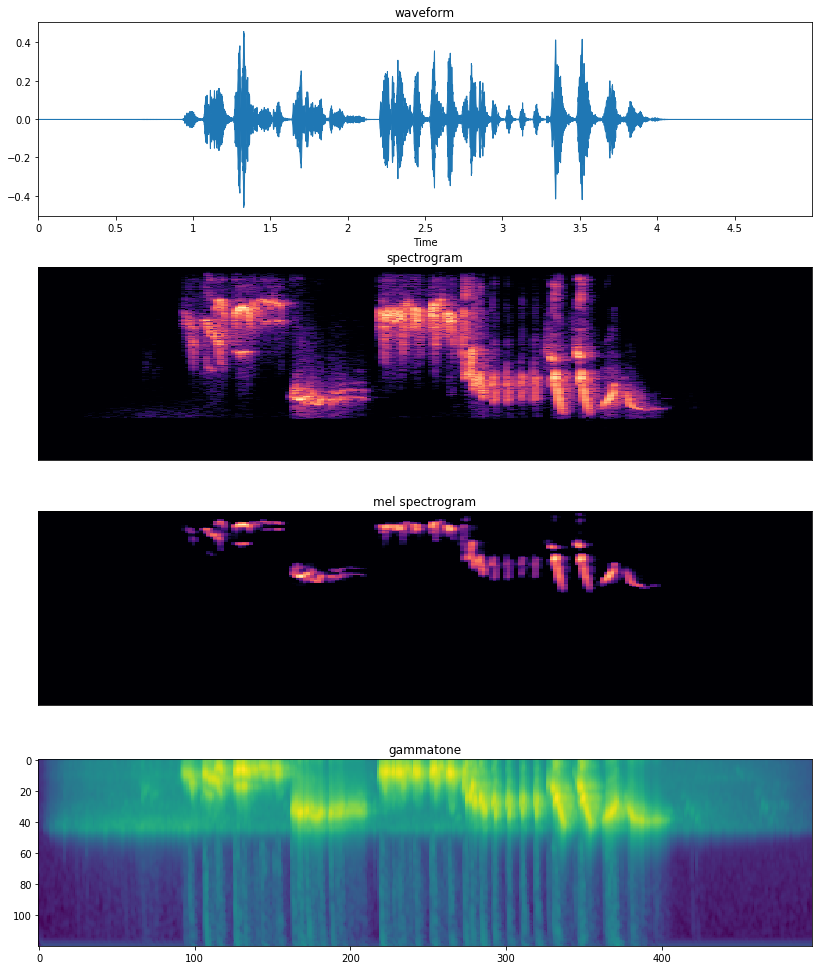

In [22]:
wav_dir = pathlib.Path('./data/wav_22050/')
for wav_path in wav_dir.glob('*.wav'):
    print(f'{wav_path.name}')
    wav, sampling_rate = librosa.core.load(wav_path, sr=None, duration=5.0)
    stft = librosa.stft(wav)
    gamma = compute_gammatone(wav)
    mel = librosa.feature.melspectrogram(y=wav, sr=sampling_rate)
    
    display(Audio(data=wav, rate=sampling_rate))
    fig, axes = plt.subplots(4, 1, figsize=(12,14))
    fig.tight_layout(pad=3.0)

    librosa.display.waveplot(wav,
                             sr=sampling_rate, ax=axes[0])
    axes[0].set_title('waveform')

    librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft), ref=np.max),
                             ax=axes[1])
    axes[1].set_title('spectrogram')

    librosa.display.specshow(librosa.amplitude_to_db(mel, ref=np.max), ax=axes[2])
    axes[2].set_title('mel spectrogram')

    axes[3].imshow(gamma)
    axes[3].set_title('gammatone')
    
    plt.show()

# Datasets

[Audioset](https://research.google.com/audioset/index.html) 
- videos from YouTube. Useful for many purposes, audio classification, urban sounds recognition, noises for augmentations.
- 2.1 million annotated videos
- 5.8 thousand hours of audio
- 527 classes of annotated sounds

[LJSpeech](https://keithito.com/LJ-Speech-Dataset/) 
- banchmark dataset for TTS models, very clean anf high quality.
- 24 hours, 13,100 short audio clips.
- single speaker reading passages from 7 non-fiction books.

[Common Voice](https://voice.mozilla.org/en)
- huge dataset with more than 50 languages and thousands of speakers.
- Might be well suited for low resources/ multi-lingual TTS models